# Natural Language Processing - lab 1 (Regular expressions)

Bartosz Klimza

# Necessary imports

In [38]:
import os 
import pandas as pd
import regex
import matplotlib.pyplot as plt

# Data preparation

In [39]:
data_dir = "./ustawy/"

# 1. For each bill compute the number of the following amendments present in the bill:
    * addition of a unit (e.g. dodaje się ust. 5a),
    * removal of a unit (e.g. w art. 10 ust. 1 pkt 8 skreśla się),
    * change of a unit (e.g. art. 5 otrzymuje brzmienie).
# 2. Note that other types of changes, e.g. po wyrazach "na dofinansowanie" dodaje się wyrazy " , z zastrzeżeniem art. 21a,", must not be included in the result.

In [40]:
points = r"(ust\.|pkt|art\.|§) \d*\p{Ll}*"
addition = r"dodaje [się ]*" + points
removal = r"\b((w " + points + r" (skreśla|uchyla) [się]*)|((skreśla|uchyla) [się ]*" + points + r"))"
change = points + r" otrzymuje brzmienie"
for_year = r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s(?:KONSTYTUCYJNA|BUDŻETOWA\s*NA ROK \d{4}|\s*)\s*z dnia \d{1,2} (?:stycznia|lutego|marca|kwietnia|maja|czerwca|lipca|sierpnia|września|października|listopada|grudnia) \d{4}"

In [41]:
def extract_year(bill):
    year = regex.findall(for_year, bill)
    if year:  
        return year[0][-4:]
    else: # One bill hasn't an electronic version, so I'll return 0 for this year
        return 0

results = pd.DataFrame(columns = ['Additions', 'Removals' , 'Changes', 'Year'])
for file in os.listdir(data_dir):
    bill = open(os.path.join(data_dir, file), 'r').read()
    bill = bill.split()
    bill = " ".join(bill) 
    additions = len(regex.findall(addition, bill))   
    removals = len(regex.findall(removal, bill))    
    changes = len(regex.findall(change, bill))
    results.loc[file] = [additions, removals, changes, extract_year(bill)]
results['All'] = results['Additions'] + results['Removals'] + results['Changes']
results

,Additions,Removals,Changes,Year,All
2001_874.txt,0,0,1,2001,1
1996_583.txt,0,1,2,1996,3
2003_1853.txt,13,1,28,2003,42
1997_753.txt,4,1,5,1997,10
2000_440.txt,0,0,0,2000,0
...,...,...,...,...,...
2004_1378.txt,33,6,43,2015,82
1995_471.txt,1,1,2,1999,4
2003_1692.txt,33,5,40,2013,78
1995_1.txt,0,2,0,1994,2


# 3. Plot results from point 1 showing how the percentage of amendments of a given type changed in the consecutive years

In [42]:
annual = results.groupby(["Year"]).sum()
annual['Additions \[%\]'] = annual['Additions'] / annual['All']
annual['Removals \[%\]'] = annual['Removals'] / annual['All']
annual['Changes \[%\]'] = annual['Changes'] / annual['All']
annual['Removals'].sum()

2711

<Figure size 1440x1440 with 0 Axes>

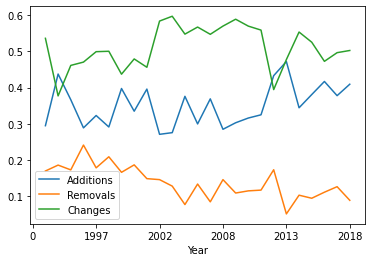

In [43]:
fig = plt.figure(figsize =(20,20)) 
fig = {'Additions': annual['Additions \[%\]'],
        'Removals': annual['Removals \[%\]'],
        'Changes':annual['Changes \[%\]']}

fig = pd.DataFrame(fig)
fig.plot(y=['Additions', 'Removals', 'Changes'])
plt.show()

# 4. Compute the total number of occurrences of the word ustawa in any inflectional form (ustawa, ustawie, ustawę, etc.) and all spelling forms (ustawa, Ustawa, USTAWA), excluding other words with the same prefix (e.g. ustawić).

In [44]:
""" 
Inflective forms of "ustawa" word: ustawa, ustawy, ustawach, 
ustaw, ustawę, ustawą, ustawie, ustawo, ustawom, ustawami
"""
ustawa_regex_list = [r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Y|y)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:C|c)\s*(?:H|h)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ę|ę)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ą|ą)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:I|i)\s*(?:E|e)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\s*(?:M|m)\b",
                    r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:M|m)\s*(?:I|i)\b"]
ustawa_word_counter = 0
for file in os.listdir(data_dir):
    bill = open(os.path.join(data_dir, file), 'r').read()
    bill = bill.split()
    bill = " ".join(bill)
    for r in ustawa_regex_list:
        ustawa_word_counter += len(regex.findall(r, bill))
ustawa_word_counter            

25232

# 5. Compute the total number of occurrences of the same word (same conditions), followed by z dnia expression.

In [45]:
ustawa_followed_by_z_dnia_regex_form_list = [r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Y|y)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:C|c)\s*(?:H|h)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ę|ę)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ą|ą)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:I|i)\s*(?:E|e)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\s*(?:M|m)\b(?= z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:M|m)\s*(?:I|i)\b(?= z dnia)"]

ustawa_word_z_dnia_counter = 0
for file in os.listdir(data_dir):
    bill = open(os.path.join(data_dir, file), 'r').read()
    bill = bill.split()
    bill = " ".join(bill)
    for r in ustawa_followed_by_z_dnia_regex_form_list:
        ustawa_word_z_dnia_counter += len(regex.findall(r, bill))
ustawa_word_z_dnia_counter

8729

# 6. As above, but not followed by z dnia expression. Is the result correct (result 4 =? result 5 + result 6)?

In [46]:
ustawa_not_followed_by_z_dnia_regex_form_list = [r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Y|y)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:C|c)\s*(?:H|h)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ę|ę)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ą|ą)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:I|i)\s*(?:E|e)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\s*(?:M|m)\b(?! z dnia)",
                                             r"(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:M|m)\s*(?:I|i)\b(?! z dnia)"]

ustawa_word_z_dnia_nf_counter = 0
for file in os.listdir(data_dir):
    bill = open(os.path.join(data_dir, file), 'r').read()
    bill = bill.split()
    bill = " ".join(bill)
    for r in ustawa_not_followed_by_z_dnia_regex_form_list:
        ustawa_word_z_dnia_nf_counter += len(regex.findall(r, bill))
ustawa_word_z_dnia_nf_counter

16503

In [47]:
if ustawa_word_z_dnia_counter + ustawa_word_z_dnia_nf_counter == ustawa_word_counter:
    print("Correct result!")
else:
    print("Not correct result!")

Correct result!


# 7. Compute the total number of occurrences of the word ustawa in any inflectional form, excluding occurrences following o zmianie expression.

In [50]:
ustawa_o_zmianie_regex_form_list = [r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Y|y)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:C|c)\s*(?:H|h)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ę|ę)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:Ą|ą)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:I|i)\s*(?:E|e)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:O|o)\s*(?:M|m)\b",
                                    r"(?<!o zmianie )(?:U|u)\s*(?:S|s)\s*(?:T|t)\s*(?:A|a)\s*(?:W|w)\s*(?:A|a)\s*(?:M|m)\s*(?:I|i)\b"]

ustawa_word_o_zmianie_counter = 0
for file in os.listdir(data_dir):
    bill = open(os.path.join(data_dir, file), 'r').read()
    bill = bill.split()
    bill = " ".join(bill)
    for r in ustawa_o_zmianie_regex_form_list:
        ustawa_word_o_zmianie_counter += len(regex.findall(r, bill))
ustawa_word_o_zmianie_counter

24361

# 8. Plot results 4-7 using a bar chart.

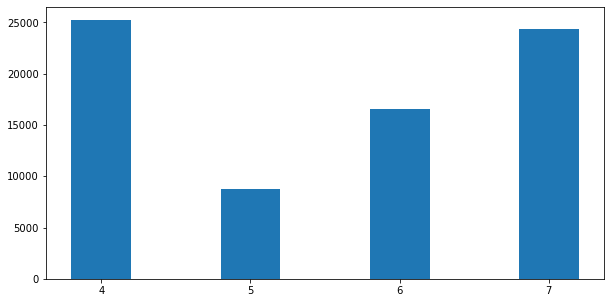

In [51]:
data = {'4':ustawa_word_counter,
        '5':ustawa_word_z_dnia_counter,
        '6':ustawa_word_z_dnia_nf_counter,
        '7':ustawa_word_o_zmianie_counter}
exercises = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))

plt.bar(exercises, values, width = 0.4)
plt.show()